# One week of LEO - (conjunctions)
In this example we will consider the tracked population of objects orbiting in Low Earth Orbit and run a simulation while detecting all conjunctions and removing decayed objects
. The simulation is similar to the one described in the cascade example [20 Years in LEO - (collisions)](<./../examples/20yearsofLEO_coll.ipynb>), but instead of tracking actual collisions, it tracks all conjunctions between orbiting objects within some defined radius (e.g. 5km). The simulation is helpful from the operational point of view if one wants to generate warnings in advance for potentially risky events. It performs similar computations to the [SOCRATES](https://celestrak.org/SOCRATES/) web resource, but using [heyoka](https://bluescarni.github.io/heyoka.py/) as a numerical propagator, a high fidelity dynamical model instead of the [SGP4](https://en.wikipedia.org/wiki/Simplified_perturbations_models), and cascade original algorithm to efficiently track and compute all conjunctions instead of the [STK](https://www.agi.com/products) conjunction analysis module.

We start, as always, with some imports:

In [1]:
# Core imports
import pykep as pk
import numpy as np
import pickle as pkl
import cascade as csc
from copy import deepcopy

# Plotting
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt
%matplotlib inline

## Loading the initial LEO population
Let us define the initial LEO population from the objects tracked by the [US Space Surveillance Network (SSN)](https://en.wikipedia.org/wiki/United_States_Space_Surveillance_Network). 
The necessary steps to prepare such data are described by the code made available as a cascade utility in [The current LEO population](<./../utilities/leo_population.ipynb>)

The file needed is:
* **leo_population.pk** - created by [The current LEO population](<./../utilities/leo_population.ipynb>) notebook.

In [2]:
# r is in km and v in km/s
with open("data/leo_population.pk", "rb") as file:
    r_ic,v_ic,to_satcat_index,satcat = pkl.load(file)

# reference epoch for the initial conditions
t0_jd = pk.epoch_from_iso_string("20220301T000000").jd # Julian date corresponding to 2022-Mar-01 00:00:00

* **r_ic**: contains the initial position of all satellites to be simulated (in km)
* **v_ic**: contains the initial velocity of all satellites to be simulated (in km/sec)
* **to_satcat_index**: contains the indexes in the satcat of the corresponding r_ic,v_ic entry
* **satcat**: the database created of all tracked objects

The object described by the entry ```satcat[to_satcat_index[j]]``` has initial position ```r_ic[j]``` and initial velocity ```v_ic[j]```.

On top of all the info distributed from the [US Space Surveillance Network (SSN)](https://en.wikipedia.org/wiki/United_States_Space_Surveillance_Network) we have added to the satcat (see [The current LEO population](<./../utilities/leo_population.ipynb>) notebook) dictionary an estimate of the object radius which we will need to define the various collisional radii. As we will be using a dynamics that also models the atmospheric drag via the BSTAR coefficient, we create the array to be used as parameter when instantiating a :class:`~cascade.sim`.

In [3]:
# Array containing the BSTAR coefficient in the SI units used
BSTARS = []
RADIUS = []
for idx in to_satcat_index:
    BSTARS.append(float(satcat[idx]["BSTAR"]))
    RADIUS.append(float(satcat[idx]["RADIUS"]))
# We transform the BSTAR in SI units
BSTARS = np.array(BSTARS) / pk.EARTH_RADIUS
RADIUS = np.array(RADIUS)
# .. and remove negative BSTARS (this can happen for objects that where performing orbital manouvres during the tle definition) setting the value to zero in those occasions.
BSTARS[BSTARS<0] = 0.
# We also transform r_ic and v_ic in SI
r_ic = r_ic*1000
v_ic = v_ic*1000

## Building the dynamical system to integrate
The dynamics in the LEO environment is dominated by drag and gravitational effects. The effect of the Moon gravity, Sun gravity and solar radiation pressure are much weaker and thus not considered here, even if they would not add much complexity in the simulation. We make use of the cascade class `cascade.dynamics.simple_earth` returning analytical expressions for such a dynamics.

In [4]:
dyn =  csc.dynamics.simple_earth(J2=True, J3 = False, C22S22=True, sun=False,moon=False,SRP=False,drag=True)

## Setup of the simulation

The global cascade logger is here informed of the level of information we want to be reported to screen during the simulation. We also set the number of threads to be used to 32, clearly this number depends on the resources available on the particular computer used to run the simulation and the ability to run the threads in parallel.

In [5]:
csc.set_logger_level_info()
csc.set_nthreads(32)

We now define the radius that will be used to check for decayed objects. We will assume that once the position of some object is below 150km altitude, the object can be considered as decayed.

In [6]:
reentry_radius = pk.EARTH_RADIUS+150000.

In [7]:
# Detecting the particles
inside_the_radius = np.where(np.linalg.norm(r_ic,axis=1) < reentry_radius)[0]
print("Removing ", len(inside_the_radius), " orbiting objects:")
for idx in inside_the_radius:
    print(satcat[to_satcat_index[idx]]["OBJECT_NAME"], "-", satcat[to_satcat_index[idx]]["OBJECT_ID"])

# Deleting the particles
r_ic = np.delete(r_ic, inside_the_radius, axis=0)
BSTARS = np.delete(BSTARS, inside_the_radius, axis=0)
RADIUS = np.delete(RADIUS, inside_the_radius, axis=0)
v_ic = np.delete(v_ic, inside_the_radius, axis=0)
to_satcat_index = np.delete(to_satcat_index, inside_the_radius, axis=0)


Removing  22  orbiting objects:
LEMUR 2 ROCKETJONAH - 2017-071E
ISARA - 2017-071P
FREGAT DEB - 2011-037EM
STARLINK-1684 - 2020-070H
COSMOS 1408 DEB - 1982-092Z
COSMOS 1408 DEB - 1982-092AK
COSMOS 1408 DEB - 1982-092ES
COSMOS 1408 DEB - 1982-092FK
COSMOS 1408 DEB - 1982-092FY
COSMOS 1408 DEB - 1982-092GU
COSMOS 1408 DEB - 1982-092NA
COSMOS 1408 DEB - 1982-092PV
COSMOS 1408 DEB - 1982-092PW
COSMOS 1408 DEB - 1982-092RM
COSMOS 1408 DEB - 1982-092ACG
COSMOS 1408 DEB - 1982-092AQC
COSMOS 1408 DEB - 1982-092ARK
COSMOS 1408 DEB - 1982-092AXA
COSMOS 1408 DEB - 1982-092AXD
COSMOS 1408 DEB - 1982-092BDB
COSMOS 1408 DEB - 1982-092BFU
COSMOS 1408 DEB - 1982-092BKD


We can now instantiate the cascade simulation. This will trigger the [LLVM](https://en.wikipedia.org/wiki/LLVM) compilation of the needed Taylor integrators representing the selected dynamics as well as the event detection, thus taking a few seconds. 
Note that this cost is to be paid only once. As far as the dynamics remains unchanged other simulations can be made reusing the same object.

As a collisional timestep, a parameter that can be tuned to get the best efficiency, we use the value of the ISS orbital period divided by 40. 

In [8]:
# Prepare the data in the shape expected by the simulation object.
ic_state = np.hstack([r_ic, v_ic, RADIUS.reshape((r_ic.shape[0], 1))])
BSTARS = BSTARS.reshape((r_ic.shape[0], 1))
# The collisional timestep is set to 1/40 of the ISS orbital period
collisional_step = 90*60. / 40
sim = csc.sim(ic_state, collisional_step, dyn=dyn, pars=BSTARS, reentry_radius=reentry_radius, n_par_ct = 120, conj_thresh = 5000, min_coll_radius=float('inf'))

we also need to set the starting time of the simulation so that the dynamics, written in the EME2000 reference frame (see ~{class}`sim.dynamics.simple_earth`) will be correctly using the Sun, Moon and Earth positions at the time of the initial conditions.

In [ ]:
# We define here the simulation starting time knowing that in the dynamics t=0 corresponds to 1st Jan 2000 12:00. 
t0 = (t0_jd - pk.epoch_from_iso_string("20000101T120000").jd) * pk.DAY2SEC
sim.time = t0

Note that with respect to the simulation [20 Years in LEO - (collisions)](<./../examples/20yearsofLEO_coll.ipynb>) we have here added the `conj_thresh` argument setting it to 5000 m and a ``min_coll_radius`` argument setting it to infinity. The effect of the first argument will be that of activating conjunction tracking. All close encounters with a distance smaller than the `conj_thresh` are guaranteed to be detected and reported. The effect of setting an infinite ``min_coll_radius`` is that of deactivating entirely the collision checks as we are informing cascade to ignore all collisions involving object of size smaller than ``min_coll_radius``.

## Running the simulation


In [9]:
import time
final_t = t0 + 7 * pk.DAY2SEC
print("Starting the simulation:", flush=True)
start = time.time()

current_year = 0
while sim.time < final_t:
    years_elapsed = (sim.time - t0) * pk.SEC2DAY // 365.25

    if years_elapsed == current_year:
        with open("out/year_"+str(current_year)+".pk", "wb") as file:
            pkl.dump((sim.state, sim.pars, to_satcat_index), file)
        current_year += 1

    oc = sim.step()

    if oc == csc.outcome.collision:
        pi, pj = sim.interrupt_info
        # We log the event to file
        satcat_idx1 = to_satcat_index[pi]
        satcat_idx2 = to_satcat_index[pj]
        days_elapsed = (sim.time - t0) * pk.SEC2DAY
        with open("out/collision_log.txt", "a") as file_object:
            file_object.write(
                f"{days_elapsed}, {satcat_idx1}, {satcat_idx2}, {sim.state[pi]}, {sim.state[pj]}\n")
        # We log the event to screen
        o1, o2 = satcat[satcat_idx1]["OBJECT_TYPE"], satcat[satcat_idx2]["OBJECT_TYPE"]
        s1, s2 = satcat[satcat_idx1]["RCS_SIZE"], satcat[satcat_idx2]["RCS_SIZE"]
        print(
            f"\nCollision detected, {o1} ({s1}) and {o2} ({s2}) after {days_elapsed} days\n")
        # We remove the objects and restart the simulation
        sim.remove_particles([pi,pj])
        to_satcat_index = np.delete(to_satcat_index, [max(pi,pj)], axis=0)        
        to_satcat_index = np.delete(to_satcat_index, [min(pi,pj)], axis=0)


    elif oc == csc.outcome.reentry:
        pi = sim.interrupt_info
        # We log the event to file
        satcat_idx = to_satcat_index[pi]
        days_elapsed = (sim.time - t0) * pk.SEC2DAY
        with open("out/decay_log.txt", "a") as file_object:
            file_object.write(f"{days_elapsed},{satcat_idx}\n")
        # We log the event to screen
        print(satcat[satcat_idx]["OBJECT_NAME"].strip(
        ) + ", " + satcat[satcat_idx]["OBJECT_ID"].strip() + ", ", days_elapsed, "REMOVED")
        # We remove the re-entered object and restart the simulation
        sim.remove_particles([pi])
        to_satcat_index = np.delete(to_satcat_index, [pi], axis=0)    
end = time.time()
elapsed = end - start
print("Total number of conjunction events: ", len(sim.conjunctions))
print("Elapsed [s]: ", end - start)


Starting the simulation:
COSMOS 1408 DEB, 1982-092FH,  0.0011408778035688443 REMOVED
COSMOS 1408 DEB, 1982-092GM,  0.004103107049680436 REMOVED
SL-4 R/B, 2006-061B,  0.005706346635533298 REMOVED
FREGAT DEB, 2011-037ET,  0.00726722705964723 REMOVED
CZ-3B R/B, 2021-010B,  0.018153158895113 REMOVED
COSMOS 1408 DEB, 1982-092AEC,  0.029553074924155966 REMOVED
COSMOS 2241, 1993-022A,  0.04331453960721235 REMOVED
CZ-3B R/B, 2021-003B,  0.060801873198829806 REMOVED
FREGAT DEB, 2011-037LV,  0.0734482434177867 REMOVED
FREGAT DEB, 2011-037NV,  0.07891368611169422 REMOVED
COSMOS 1408 DEB, 1982-092UM,  0.07916911004311636 REMOVED
COSMOS 1408 DEB, 1982-092AHN,  0.11593168685606152 REMOVED
STARLINK-1919, 2020-074AG,  0.15779188442335854 REMOVED
COSMOS 1408 DEB, 1982-092KJ,  0.5272320889700238 REMOVED
COSMOS 2251 DEB, 1993-036AEZ,  0.6734418045797612 REMOVED
COSMOS 1408 DEB, 1982-092GN,  1.1280069915903153 REMOVED
FALCON 9 DEB, 2020-055BR,  1.1870443571144722 REMOVED
COSMOS 1408 DEB, 1982-092SQ,  1.32

The total simulation time, ultimately determined by the underlying CPU architecture, is sensitive also to the choices made for  `n_par_ct` and `collisional_step` which determine the efficient use of the CPUs as well as the perfromances of the underlying original collision detection algorithm based on the manipulation of the dense output of the Taylor integrators.

It is worth here noting that for this week long prediction and all the current tracked LEO population it takes less tha 30 seconds on 32 parallel threads!

## We make some visualization of the conjunction data

In [11]:
conj = sim.conjunctions
conj_n = len(conj)
conj_d = sim.conjunctions['dist']
v_rel = (conj["state_i"][:,3:]  - conj["state_j"][:,3:]) / 1000
pos = np.array([(conj[i][4])[:3] for i in range(len(conj))]) / pk.EARTH_RADIUS

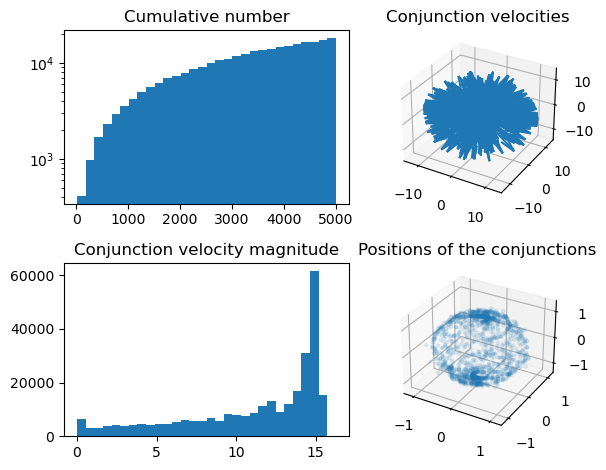

In [12]:
fig = plt.figure()
ax1 = fig.add_subplot(2,2,1)
ax1.hist(conj_d, bins=30, log=True)
ax1.set_title("Cumulative number")

ax2 = fig.add_subplot(2,2,2, projection='3d')
N=500
arrows = np.concatenate((np.zeros((N,3)), v_rel[:N]), axis=1)
X, Y, Z, U, V, W = zip(*arrows)

ax2.quiver(X, Y, Z, U, V, W)
ax2.set_title("Conjunction velocities")


ax2.set_xlim([-14, 14])
ax2.set_ylim([-14, 14])
ax2.set_zlim([-14, 14])

ax3 = fig.add_subplot(2,2,3)
plt.hist(np.linalg.norm(v_rel, axis=1), bins=30)
ax3.set_title("Conjunction velocity magnitude")

ax4 = fig.add_subplot(2,2,4, projection='3d')
N=1500
ax4.scatter(pos[:N,0], pos[:N,1], pos[:N,2], alpha=0.1, s=5)
ax4.set_title("Positions of the conjunctions")

plt.tight_layout()